In [1]:
from scipy.optimize import fsolve, newton

class pl_lens(object):
    def __init__(self,co,n=1.0,zl=0.5,zs=2.0,thetae=1.0):
        self.n=n
        self.thetae=thetae
        self.co=co
        
    def kappa(self,x):
        return((3.0-self.n)/2.0*np.abs(x)**(1.0-self.n))
    
    def gamma(self,x):
        return(np.abs((self.n-1.0)/2.0*np.abs(x)**(1.0-self.n)))
    
    def mass(self,x):
        return(np.abs(x)**(3.0-self.n))
    
    def alpha(self,x):
        return(np.sign(x)*np.abs(x)**(2.0-self.n))
    
    def lambdar(self,x):
        return 1-(2.0-self.n)*np.abs(x)**(1.0-self.n)

    def lambdat(self,x):
        return 1-np.abs(x)**(1.0-self.n)
    
    def radcl(self):
        return((2.0-self.n)**(1./(self.n-1)))

    def radcau(self):
        return -(self.radcl()-self.alpha(self.radcl()))

    def ext_source(self,yc1,yc2,rs):
        phi=np.linspace(0,2.*np.pi,1000)
        y1=yc1+rs*np.cos(phi)
        y2=yc2+rs*np.sin(phi)
        return(y1,y2,phi)
    
    def ext_images(self,yc1,yc2,rs):
        y1,y2,phi2=self.ext_source(yc1,yc2,rs)
        ys=np.sqrt(y1*y1+y2*y2)
        xi1=[]
        xi2=[]
        xi3=[]
        phi1=[]
        phi2=[]
        phi3=[]
        for j in range(len(ys)):
            def func(xx):
                return (xx-ys[j]-pl.alpha(xx))
            x0_ = fsolve(func,ys[j]+1.0)
            x1_ = fsolve(func,ys[j]-1.0)
            x3_ = fsolve(func,0.0)
            phi=np.arctan2(y2[j],y1[j])
            if (np.abs(func(x0_))<1e-8):
                xi1.append(x0_)
                phi1.append(phi)
            if (np.abs(func(x1_))<1e-8 and (np.sign(x1_) != np.sign(ys[j]))):
                xi2.append(x1_)
                phi2.append(phi)
            if (np.abs(func(x3_))<1e-8 and (np.sign(x1_) != np.sign(ys[j]))):
                xi3.append(x3_)
                phi3.append(phi)
        xi1=np.array(xi1).reshape(len(xi1))
        xi2=np.array(xi2).reshape(len(xi2))
        xi3=np.array(xi3).reshape(len(xi3))
        return(xi1,phi1,xi2,phi2,xi3,phi3)
    
    def pot_power(self,x):
        return 1.0/(3.0-self.n)*np.abs(x)**(3.0-self.n)
    
    #utils
    def SigmaCrit(self):
        from astropy.constants import c, G
        dl=self.co.angular_diameter_distance(self.zl)
        ds=self.co.angular_diameter_distance(self.zs)
        dls=self.co.angular_diameter_distance_z1z2(self.zl,self.zs)
        c2_G_Msun_Mpc = (c**2/G).to(u.Msun/u.Mpc)
        sigma_cr = c2_G_Msun_Mpc/(4*np.pi)*(ds/dl/dls)
        return(sigma_cr)
    


(1024, 1024) (1024, 1024)
Einstein Radius (theta_E): 30 arcsec
Kritik Yüzey Yoğunluğu (Sigma_crit): 2.444e-30 Msun/m^2
Toplam Kütle (M): 1.353e+14 Msun


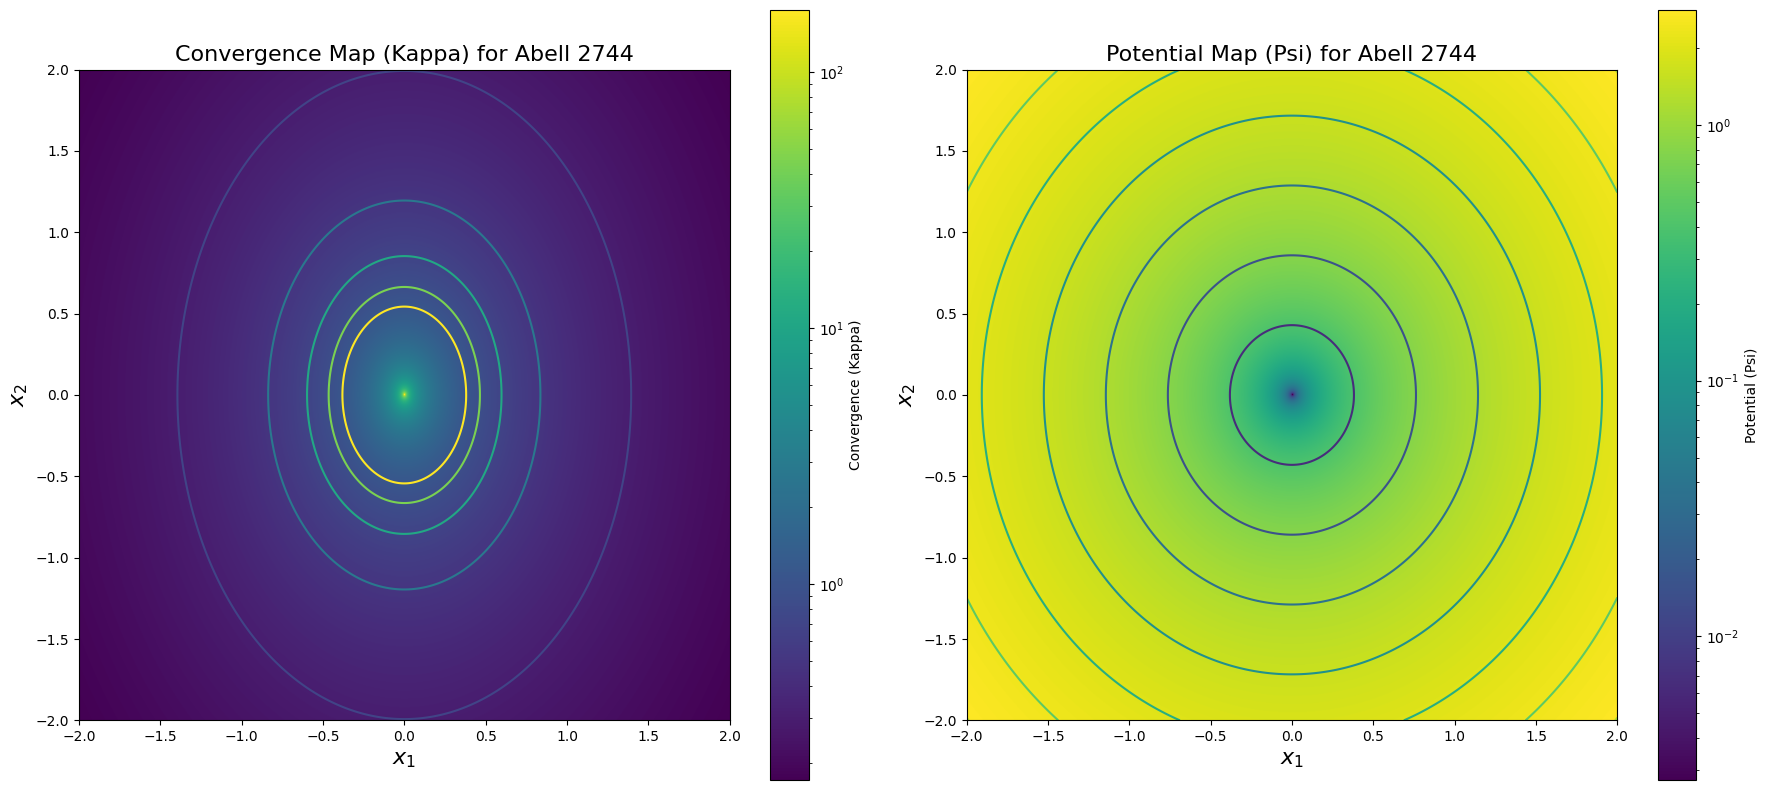

In [2]:
import numpy as np
from astropy.constants import c, G

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.patches import Ellipse
from scipy.optimize import fsolve, newton,brenth, brentq

class sie_lens(object):
    
    def __init__(self,co,sigmav=200,zl=0.3,zs=2.0,f=0.6):
        self.sigmav=sigmav
        self.co=co
        self.zl=zl
        self.zs=zs
        self.f=f
        self.dl=self.co.angular_diameter_distance(self.zl)
        self.ds=self.co.angular_diameter_distance(self.zs)
        self.dls=self.co.angular_diameter_distance_z1z2(self.zl,self.zs)
        xi0 = 4.0*np.pi*sigmav**2/c**2*self.dl*self.dls/self.ds
    
    def delta(self,f,phi):
        return np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
    
    def kappa(self,x,phi):
        return(np.sqrt(self.f)/2.0/x/self.delta(self.f,phi))
    
    def gamma(self,x,phi):
        return(-self.kappa(x,phi)*np.cos(2.0*phi),
               -self.kappa(x,phi)*np.sin(2.0*phi))
    
    def mu(self,x,phi):
        ga1,ga2=self.gamma(x,phi)
        ga=np.sqrt(ga1*ga1+ga2*ga2)
        return 1.0/(1.0-self.kappa(x,phi)-ga)/(1.0-self.kappa(x,phi)+ga)

    def kappa_map(self,x_,y_):
        xk,yk=np.meshgrid(x_,y_)
        phi=np.arctan2(yk,xk)
        x=np.sqrt(xk*xk+yk*yk)
        ka=self.kappa(x,phi)
        print (ka.shape,xk.shape)
        #ka=np.array(ka).reshape([xk.size,yk.size],order='F')
        return(ka)
    
    def psi_tilde(self,phi):
        if (self.f < 1.0):
            fp=np.sqrt(1.0-self.f**2)
            return np.sqrt(self.f)/fp*(np.sin(phi)*np.arcsin(fp*np.sin(phi))+
                                       np.cos(phi)*np.arcsinh(fp/f*np.cos(phi)))
        else: 
            return(1.0)

    def psi(self,x,phi):
        psi=x*self.psi_tilde(phi)
        return psi
    
    def pot_map(self,x_,y_):
        xk,yk=np.meshgrid(x_,y_)
        phi=np.arctan2(yk,xk)
        x=np.sqrt(xk*xk+yk*yk)
        psi_map=self.psi(x,phi)
        return(np.abs(psi_map))
    
    def alpha(self,phi):
        fp=np.sqrt(1.0-self.f**2)
        a1=np.sqrt(self.f)/fp*np.arcsinh(fp/self.f*np.cos(phi))
        a2=np.sqrt(self.f)/fp*np.arcsin(fp*np.sin(phi))
        return a1,a2
    
    def alpha_map(self,x_,y_):
        xk,yk=np.meshgrid(x_,y_)
        phi=np.arctan2(yk,xk)
        x=np.sqrt(xk*xk+yk*yk)
        a1,a2=self.alpha(phi)
        return(a1,a2)
    
    def cut(self,phi_min=0,phi_max=2.0*np.pi):
        phi=np.linspace(phi_min,phi_max,1000)
        y1,y2=self.alpha(phi)
        return -y1,-y2


    def tan_caustic(self,phi_min=0,phi_max=2.0*np.pi):
        phi=np.linspace(phi_min,phi_max,1000)
        delta=np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
        a1,a2=self.alpha(phi)
        y1=np.sqrt(self.f)/delta*np.cos(phi)-a1
        y2=np.sqrt(self.f)/delta*np.sin(phi)-a2
        return y1,y2  

    def tan_cc(self,phi_min=0,phi_max=2.0*np.pi):
        phi=np.linspace(phi_min,phi_max,1000)
        delta=np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
        r=np.sqrt(self.f)/delta
        x1=r*np.cos(phi)
        x2=r*np.sin(phi)
        return(x1,x2) 
    
    
    def cut_intercept_y1(self):
        s1,y2_tmp=self.alpha(0.0)
        return (s1)

    def cut_intercept_y2(self):
        y1_tmp,s1=self.alpha(np.pi/2.0)
        return (s1)

    def cau_intercept_y1(self):
        a1,a2=self.alpha(np.pi/2.0)
        s1=np.sqrt(self.f)-a1
        return (s1)

    def cau_intercept_y2(self):
        a1,a2=self.alpha(np.pi/2.0)
        s1=np.sqrt(self.f)/self.f-a2
        return (s1)

    def x_ima(self,y1,y2,phi):
        x=y1*np.cos(phi)+y2*np.sin(phi)+(self.psi_tilde(phi))
        return x

    def phi_ima(self,y1,y2,checkplot=True,verbose=True):
        def phi_func(phi):
            a1,a2=self.alpha(phi)
            func=(y1+a1)*np.sin(phi)-(y2+a2)*np.cos(phi)
            return func

        U=np.linspace(0.,2.0*np.pi+0.001,100)
        c = phi_func(U)
        s = np.sign(c)
        phi=[]
        xphi=[]
        for i in range(100-1):
            if s[i] + s[i+1] == 0: # opposite signs
                u = brentq(phi_func, U[i], U[i+1])
                z = phi_func(u)
                if np.isnan(z) or abs(z) > 1e-3:
                    continue
                x=self.x_ima(y1,y2,u)
                if (x>0):
                    phi.append(u)
                    xphi.append(x)
                if (verbose):
                    print('found zero at {}'.format(u))
                    if (x<0):
                        print ('discarded because x is negative ({})'.format(x))
                    else:
                        print ('accepted because x is positive ({})'.format(x))
        if (checkplot):        
            phi_=np.linspace(0.,2.0*np.pi,100)
            ax[0].plot(phi_,phi_func(phi_),label=r'$F(\varphi)$')
            ax[0].plot(phi_,self.x_ima(y1,y2,phi_),label=r'$x(\varphi)$')
            #ax[0].plot(phi_,psi_tilde(phi_,f)-1)
            ax[0].plot(phi,phi_func(phi),'o',markersize=8)
            ax[0].set_xlabel(r'$\varphi$',fontsize=20)
            ax[0].set_ylabel(r'$F(\varphi),x(\varphi)$',fontsize=20)
            ax[0].legend(fontsize=16)
    
        return(np.array(xphi),np.array(phi))

    def ext_source(self,yc1,yc2,rs,npt=720):
        phi=np.linspace(0,2.*np.pi,npt)
        y1=yc1+rs*np.cos(phi)
        y2=yc2+rs*np.sin(phi)
        return(y1,y2)
    
    def ext_image(self,yc1,yc2,rs,npt=720):
        y1,y2=self.ext_source(yc1,yc2,rs,npt)
        x=[]
        phi=[]
        for i in range(len(y1)):
            x_,phi_=self.phi_ima(y1[i],y2[i],checkplot=False,verbose=False)
            for j in range(len(x_)):
                x.append(x_[j])
                phi.append(phi_[j])
        return(x,phi)
            
    
    #utils
    def SigmaCrit(self):
        from astropy.constants import c, G
        c2_G_Msun_Mpc = (c**2/G).to(u.Msun/u.Mpc)
        sigma_cr = c2_G_Msun_Mpc/(4*np.pi)*(self.ds/self.dl/self.dls)
        return(sigma_cr)
    

from astropy.cosmology import FlatLambdaCDM
co = FlatLambdaCDM(H0=70, Om0=0.3)

f=0.7 # axis radio
z_lens = 0.17
z_source = 2.0  # Source redshift
sigma_v = 1400  # Velocity dispersion in km/s (Abell 2744 için yaklaşık değer)

xmin=-2
xmax=2
ymin=-2
ymax=2
npix=1024





# Koordinatları oluştur

xk = np.linspace(xmin, xmax, npix)

yk = np.linspace(ymin, ymax, npix)



# Abell 2744 için lens modeli

sie_abell2218 = sie_lens(co, sigmav=sigma_v, zl=z_lens, zs=z_source, f=f)



# Kappa (yoğunluk) ve potansiyel haritalarını hesaplayalım

kappa_abell = sie_abell2218.kappa_map(xk, yk)

pot_abell = sie_abell2218.pot_map(xk, yk)



# Görselleştirme

fig, ax = plt.subplots(1, 2, figsize=(18, 8))



# Kappa haritası (yoğunluk)

im0 = ax[0].imshow(kappa_abell, norm=LogNorm(), origin='lower', extent=[xmin, xmax, ymin, ymax])

cs0 = ax[0].contour(kappa_abell, levels=[0.1, 0.3, 0.5, 0.7, 0.9, 1.1], extent=[xmin, xmax, ymin, ymax])

ax[0].set_title("Convergence Map (Kappa) for Abell 2744", fontsize=16)

ax[0].set_xlabel("$x_1$", fontsize=16)

ax[0].set_ylabel("$x_2$", fontsize=16)

fig.colorbar(im0, ax=ax[0], label="Convergence (Kappa)")



# Potansiyel haritası

im1 = ax[1].imshow(pot_abell, norm=LogNorm(), origin='lower', extent=[xmin, xmax, ymin, ymax])

cs1 = ax[1].contour(pot_abell, extent=[xmin, xmax, ymin, ymax])

ax[1].set_title("Potential Map (Psi) for Abell 2744", fontsize=16)

ax[1].set_xlabel("$x_1$", fontsize=16)

ax[1].set_ylabel("$x_2$", fontsize=16)

fig.colorbar(im1, ax=ax[1], label="Potential (Psi)")



plt.tight_layout()

# plt.show()



from astropy.constants import c, G
from astropy.cosmology import FlatLambdaCDM
import numpy as np

# Kozmolojik model
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Abell 2744 parametreleri
z_lens = 0.308  # Lens redshift
z_source = 2.0  # Source redshift (örnek bir kaynak)
theta_E = 30  # Einstein yarıçapı (arcsec)

# Açısal çap uzaklıkları (metre cinsinden)
D_d = cosmo.angular_diameter_distance(z_lens).to("m")  # Lens uzaklığı
D_s = cosmo.angular_diameter_distance(z_source).to("m")  # Kaynak uzaklığı
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source).to("m")  # Lens ve kaynak arasındaki uzaklık

# Kritik yüzey yoğunluğu (Sigma_crit)
Sigma_crit = (c**2 / (4 * np.pi * G) * (D_s / (D_d * D_ds))).to("kg/m2")

# Einstein yarıçapını metreye çevir
theta_E_rad = np.deg2rad(theta_E / 3600)  # Arcsec to radians
theta_E_m = theta_E_rad * D_d.value  # Einstein yarıçapı (metre)

# Toplam kütle (M)
M = np.pi * Sigma_crit.value * theta_E_m**2  # kg cinsinden

# Kütleyi Güneş kütlesine çevir
M_sun = 1.989e30  # Güneş kütlesi (kg)
M_sol = M / M_sun  # Güneş kütlesi cinsine çevir
Sigma_crit_sol = Sigma_crit.value / M_sun  # Kritik yüzey yoğunluğunu Güneş kütlesine dönüştür

# Sonuçları yazdır
print(f"Einstein Radius (theta_E): {theta_E} arcsec")
print(f"Kritik Yüzey Yoğunluğu (Sigma_crit): {Sigma_crit_sol:.3e} Msun/m^2")
print(f"Toplam Kütle (M): {M_sol:.3e} Msun")


In [3]:
from astropy.cosmology import FlatLambdaCDM
import numpy as np
from astropy.constants import G, c

class nfwcirc:
    def __init__(self, co, zl=0.308, zs=2.0, c200=4.0, m200=1e15):
        self.co = co  # Kozmolojik model
        self.zl = zl  # Lens kırmızıya kayması
        self.zs = zs  # Kaynak kırmızıya kayması
        self.m200 = m200  # Lensin toplam kütlesi (M200) [Msun]
        self.c200 = c200  # Konsantrasyon parametresi

        # Kritik yoğunluğu hesapla
        self.rhos = (
            200.0 / 3.0 * (self.co.critical_density(self.zl).to("Msun/Mpc3"))
            * self.c200**3
            / (np.log(1.0 + self.c200) - self.c200 / (1.0 + self.c200))
        )

        # r200 ve rs hesapla
        f200 = 4.0 / 3.0 * np.pi * 200.0 * self.co.critical_density(self.zl).to("Msun/Mpc3").value
        self.r200 = (self.m200 / f200) ** (1.0 / 3.0)  # Mpc cinsinden
        self.rs = self.r200 / self.c200

        # Açısal çap uzaklıklarını hesapla
        self.dl = self.co.angular_diameter_distance(self.zl).to("Mpc")
        self.ds = self.co.angular_diameter_distance(self.zs).to("Mpc")
        self.dls = self.co.angular_diameter_distance_z1z2(self.zl, self.zs).to("Mpc")

        # Kritik yüzey yoğunluğu
        self.sc = self.sigma_crit()

        # Yoğunluk ölçeği
        self.ks = self.rhos.value * self.rs / self.sc

    def sigma_crit(self):
        c2G = (c**2 / G).to("Msun/Mpc")
        factor = c2G / (4 * np.pi)
        return (factor * (self.ds / (self.dl * self.dls))).value

    def kappap(self, r):
        x = r / self.rs
        fx = np.piecewise(
            x,
            [x > 1.0, x < 1.0, x == 1.0],
            [
                lambda x: (1 - (2.0 / np.sqrt(x * x - 1.0) * np.arctan(np.sqrt((x - 1.0) / (x + 1.0))))) / (x**2 - 1),
                lambda x: (1 - (2.0 / np.sqrt(1.0 - x * x) * np.arctanh(np.sqrt((1.0 - x) / (1.0 + x))))) / (x**2 - 1),
                0.0,
            ],
        )
        kappa = 2.0 * self.ks * fx
        return kappa

    def massp(self, r):
        x = r / self.rs
        fx = np.piecewise(
            x,
            [x > 1.0, x < 1.0, x == 1.0],
            [
                lambda x: (2.0 / np.sqrt(x * x - 1.0) * np.arctan(np.sqrt((x - 1.0) / (x + 1.0)))),
                lambda x: (2.0 / np.sqrt(1.0 - x * x) * np.arctanh(np.sqrt((1.0 - x) / (1.0 + x)))),
                0.0,
            ],
        )
        massp = 4.0 * self.ks * (np.log(x / 2.0) + fx)
        return massp

# Kozmolojik model
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

z_lens = 0.308
z_source = 2.0
c200 = 4.0
m200 = 2e15 

abell_2744_lens = nfwcirc(cosmo, zl=z_lens, zs=z_source, c200=c200, m200=m200)

r = abell_2744_lens.r200  

dimensionless_mass = abell_2744_lens.massp(r)
total_mass = dimensionless_mass * m200

print(f"Abell 2744 için toplam kütle (r = r200): {total_mass:.3e} Msun")


Abell 2744 için toplam kütle (r = r200): 2.042e+15 Msun


In [4]:
from astropy.cosmology import FlatLambdaCDM
import numpy as np
from astropy.constants import G, c

class nfwcirc:
    def __init__(self, co, zl=0.308, zs=2.0, c200=4.0, m200=1e15):
        self.co = co  # Kozmolojik model
        self.zl = zl  # Lens kırmızıya kayması
        self.zs = zs  # Kaynak kırmızıya kayması
        self.m200 = m200  # Lensin toplam kütlesi (M200) [Msun]
        self.c200 = c200  # Konsantrasyon parametresi

        # Kritik yoğunluğu hesapla
        self.rhos = (
            200.0 / 3.0 * (self.co.critical_density(self.zl).to("Msun/Mpc3"))
            * self.c200**3
            / (np.log(1.0 + self.c200) - self.c200 / (1.0 + self.c200))
        )

        # r200 ve rs hesapla
        f200 = 4.0 / 3.0 * np.pi * 200.0 * self.co.critical_density(self.zl).to("Msun/Mpc3").value
        self.r200 = (self.m200 / f200) ** (1.0 / 3.0)  # Mpc cinsinden
        self.rs = self.r200 / self.c200

        # Açısal çap uzaklıklarını hesapla
        self.dl = self.co.angular_diameter_distance(self.zl).to("Mpc")
        self.ds = self.co.angular_diameter_distance(self.zs).to("Mpc")
        self.dls = self.co.angular_diameter_distance_z1z2(self.zl, self.zs).to("Mpc")

        # Kritik yüzey yoğunluğu
        self.sc = self.sigma_crit()

        # Yoğunluk ölçeği
        self.ks = self.rhos.value * self.rs / self.sc

    def sigma_crit(self):
        c2G = (c**2 / G).to("Msun/Mpc")
        factor = c2G / (4 * np.pi)
        return (factor * (self.ds / (self.dl * self.dls))).value

    def kappap(self, r):
        x = r / self.rs
        fx = np.piecewise(
            x,
            [x > 1.0, x < 1.0, x == 1.0],
            [
                lambda x: (1 - (2.0 / np.sqrt(x * x - 1.0) * np.arctan(np.sqrt((x - 1.0) / (x + 1.0))))) / (x**2 - 1),
                lambda x: (1 - (2.0 / np.sqrt(1.0 - x * x) * np.arctanh(np.sqrt((1.0 - x) / (1.0 + x))))) / (x**2 - 1),
                0.0,
            ],
        )
        kappa = 2.0 * self.ks * fx
        return kappa

    def massp(self, r):
        x = r / self.rs
        fx = np.piecewise(
            x,
            [x > 1.0, x < 1.0, x == 1.0],
            [
                lambda x: (2.0 / np.sqrt(x * x - 1.0) * np.arctan(np.sqrt((x - 1.0) / (x + 1.0)))),
                lambda x: (2.0 / np.sqrt(1.0 - x * x) * np.arctanh(np.sqrt((1.0 - x) / (1.0 + x)))),
                0.0,
            ],
        )
        massp = 4.0 * self.ks * (np.log(x / 2.0) + fx)
        return massp

# Kozmolojik model
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

z_lens = 0.308
z_source = 2.0
c200 = 4.0
m200 = 2e15 

abell_2744_lens = nfwcirc(cosmo, zl=z_lens, zs=z_source, c200=c200, m200=m200)

r = abell_2744_lens.r200  

dimensionless_mass = abell_2744_lens.massp(r)
total_mass = dimensionless_mass * m200

print(f"Abell 2744 için toplam kütle (r = r200): {total_mass:.3e} Msun")


Abell 2744 için toplam kütle (r = r200): 2.042e+15 Msun


In [7]:
import numpy as np
from astropy.constants import c, G
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.patches import Ellipse
from scipy.optimize import fsolve, newton,brenth, brentq

class sie_lens(object):

    def __init__(self,co,sigmav=200,zl=0.308,zs=2.0,f=0.6):
        """co = Cosmology model. In here we used FlatLambdaCDM,
            sigmav = Velocity dispersion parameter. 200 km/s default,
            """
        self.sigmav=sigmav
        self.co=co
        self.zl=zl
        self.zs=zs
        self.f=f
        self.dl=self.co.angular_diameter_distance(self.zl)
        self.ds=self.co.angular_diameter_distance(self.zs)
        self.dls=self.co.angular_diameter_distance_z1z2(self.zl,self.zs)
        xi0 = 4.0*np.pi*sigmav**2/c**2*self.dl*self.dls/self.ds

    def delta(self,f,phi):
        return np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
    
    def kappa(self,x,phi):
        return(np.sqrt(self.f)/2.0/x/self.delta(self.f,phi))
    
    def gamma(self,x,phi):
        return(-self.kappa(x,phi)*np.cos(2.0*phi),
               -self.kappa(x,phi)*np.sin(2.0*phi))
    
    def mu(self,x,phi):
        ga1,ga2=self.gamma(x,phi)
        ga=np.sqrt(ga1*ga1+ga2*ga2)
        return 1.0/(1.0-self.kappa(x,phi)-ga)/(1.0-self.kappa(x,phi)+ga)
    
    def kappa_map(self,x_,y_):
        xk,yk=np.meshgrid(x_,y_)
        phi=np.arctan2(yk,xk)
        x=np.sqrt(xk*xk+yk*yk)
        ka=self.kappa(x,phi)
        print (ka.shape,xk.shape)
        #ka=np.array(ka).reshape([xk.size,yk.size],order='F')
        return(ka)
    
    def psi_tilde(self,phi):
        if (self.f < 1.0):
            fp=np.sqrt(1.0-self.f**2)
            return np.sqrt(self.f)/fp*(np.sin(phi)*np.arcsin(fp*np.sin(phi))+
                                       np.cos(phi)*np.arcsinh(fp/f*np.cos(phi)))
        
        else: 
            return(1.0)
        
    def psi(self,x,phi):
        psi=x*self.psi_tilde(phi)
        return psi
    
    def pot_map(self,x_,y_):
        xk,yk=np.meshgrid(x_,y_)
        phi=np.arctan2(yk,xk)
        x=np.sqrt(xk*xk+yk*yk)
        psi_map=self.psi(x,phi)
        return(np.abs(psi_map))
    
    def alpha(self,phi):
        fp=np.sqrt(1.0-self.f**2)
        a1=np.sqrt(self.f)/fp*np.arcsinh(fp/self.f*np.cos(phi))
        a2=np.sqrt(self.f)/fp*np.arcsin(fp*np.sin(phi))
        return a1,a2
    
    def alpha_map(self,x_,y_):
        xk,yk=np.meshgrid(x_,y_)
        phi=np.arctan2(yk,xk)
        x=np.sqrt(xk*xk+yk*yk)
        a1,a2=self.alpha(phi)
        return(a1,a2)
    
    def cut(self,phi_min=0,phi_max=2.0*np.pi):
        phi=np.linspace(phi_min,phi_max,1000)
        y1,y2=self.alpha(phi)
        return -y1,-y2
    
    def tan_caustic(self,phi_min=0,phi_max=2.0*np.pi):
        phi=np.linspace(phi_min,phi_max,1000)
        delta=np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
        a1,a2=self.alpha(phi)
        y1=np.sqrt(self.f)/delta*np.cos(phi)-a1
        y2=np.sqrt(self.f)/delta*np.sin(phi)-a2
        return y1,y2  
    
    def tan_cc(self,phi_min=0,phi_max=2.0*np.pi):
        phi=np.linspace(phi_min,phi_max,1000)
        delta=np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
        r=np.sqrt(self.f)/delta
        x1=r*np.cos(phi)
        x2=r*np.sin(phi)
        return(x1,x2) 
    
    def cut_intercept_y1(self):
        s1,y2_tmp=self.alpha(0.0)
        return (s1)
    
    def cut_intercept_y2(self):
        y1_tmp,s1=self.alpha(np.pi/2.0)
        return (s1)
    
    def cau_intercept_y1(self):
        a1,a2=self.alpha(np.pi/2.0)
        s1=np.sqrt(self.f)-a1
        return (s1)
    
    def cau_intercept_y2(self):
        a1,a2=self.alpha(np.pi/2.0)
        s1=np.sqrt(self.f)/self.f-a2
        return (s1)
    
    def x_ima(self,y1,y2,phi):
        x=y1*np.cos(phi)+y2*np.sin(phi)+(self.psi_tilde(phi))
        return x
    
    def phi_ima(self,y1,y2,checkplot=True,verbose=True):

        def phi_func(phi):
            a1,a2=self.alpha(phi)
            func=(y1+a1)*np.sin(phi)-(y2+a2)*np.cos(phi)
            return func
        
        U=np.linspace(0.,2.0*np.pi+0.001,100)
        c = phi_func(U)
        s = np.sign(c)
        phi=[]
        xphi=[]

        for i in range(100-1):

            if s[i] + s[i+1] == 0: # opposite signs
                u = brentq(phi_func, U[i], U[i+1])
                z = phi_func(u)

                if np.isnan(z) or abs(z) > 1e-3:
                    continue
                x=self.x_ima(y1,y2,u)

                if (x>0):
                    phi.append(u)
                    xphi.append(x)

                if (verbose):
                    print('found zero at {}'.format(u))

                    if (x<0):
                        print ('discarded because x is negative ({})'.format(x))

                    else:
                        print ('accepted because x is positive ({})'.format(x))

        if (checkplot):        
            phi_=np.linspace(0.,2.0*np.pi,100)
            ax[0].plot(phi_,phi_func(phi_),label=r'$F(\varphi)$')
            ax[0].plot(phi_,self.x_ima(y1,y2,phi_),label=r'$x(\varphi)$')
            #ax[0].plot(phi_,psi_tilde(phi_,f)-1)
            ax[0].plot(phi,phi_func(phi),'o',markersize=8)
            ax[0].set_xlabel(r'$\varphi$',fontsize=20)
            ax[0].set_ylabel(r'$F(\varphi),x(\varphi)$',fontsize=20)
            ax[0].legend(fontsize=16)
        return(np.array(xphi),np.array(phi))
    
    def ext_source(self,yc1,yc2,rs,npt=720):
        phi=np.linspace(0,2.*np.pi,npt)
        y1=yc1+rs*np.cos(phi)
        y2=yc2+rs*np.sin(phi)
        return(y1,y2)
    
    def ext_image(self,yc1,yc2,rs,npt=720):

        y1,y2=self.ext_source(yc1,yc2,rs,npt)
        x=[]
        phi=[]

        for i in range(len(y1)):
            x_,phi_=self.phi_ima(y1[i],y2[i],checkplot=False,verbose=False)

            for j in range(len(x_)):
                x.append(x_[j])
                phi.append(phi_[j])

        return(x,phi)
    #utils
    def SigmaCrit(self):

        from astropy.constants import c, G
        c2_G_Msun_Mpc = (c**2/G).to(u.Msun/u.Mpc)
        sigma_cr = c2_G_Msun_Mpc/(4*np.pi)*(self.ds/self.dl/self.dls)
        return(sigma_cr)
    
co = FlatLambdaCDM(H0=70, Om0=0.3)

f=0.7 # axis radio
z_lens = 0.308
z_source = 2.0  # Source redshift
sigma_v = 1400  # Velocity dispersion in km/s (Abell 2744 için yaklaşık değer)
xmin=-2
xmax=2
ymin=-2
ymax=2
npix=1024

xk = np.linspace(xmin, xmax, npix)
yk = np.linspace(ymin, ymax, npix)

# Abell 2218 
sie_abell2218 = sie_lens(co, sigmav=sigma_v, zl=z_lens, zs=z_source, f=f)

# Kozmolojik model
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Abell 2744 parametreleri
z_lens = 0.17  # Lens redshift
z_source = 2.0  # Source redshift (örnek bir kaynak)
theta_E = 30  # Einstein yarıçapı (arcsec)

# Açısal çap uzaklıkları (metre cinsinden)
D_d = cosmo.angular_diameter_distance(z_lens).to("m")  # Lens uzaklığı
D_s = cosmo.angular_diameter_distance(z_source).to("m")  # Kaynak uzaklığı
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source).to("m")  # Lens ve kaynak arasındaki uzaklık

# Kritik yüzey yoğunluğu (Sigma_crit)
Sigma_crit = (c**2 / (4 * np.pi * G) * (D_s / (D_d * D_ds))).to("kg/m2")

# Einstein yarıçapını metreye çevir
theta_E_rad = np.deg2rad(theta_E / 3600)  # Arcsec to radians
theta_E_m = theta_E_rad * D_d.value  # Einstein yarıçapı (metre)


M = np.pi * Sigma_crit.value * theta_E_m**2  # kg cinsinden

M_sun = 1.989e30  
M_sol = M / M_sun  
Sigma_crit_sol = Sigma_crit.value / M_sun  

print(f"Einstein Radius (theta_E): {theta_E} arcsec")
print(f"Kritik Yüzey Yoğunluğu (Sigma_crit): {Sigma_crit_sol:.3e} Msun/m^2")
print(f"Toplam Kütle (M): {M_sol:.3e} Msun")


Einstein Radius (theta_E): 30 arcsec
Kritik Yüzey Yoğunluğu (Sigma_crit): 3.377e-30 Msun/m^2
Toplam Kütle (M): 7.635e+13 Msun
